## Key Idea:
The concept of nonparamteric attention is introduced. To find output at a particular point, we take weighted sum of knwon outputs of training set. The weights that are assigned to each output is determined by a nonparameteric function. Hence the name.  
$$f(x) = \Sigma_{i = 1}^n{\alpha(x, x_i)y_i}$$


In [1]:
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)
tf.random.set_seed(seed = 1322)

Tensorflow Version:  2.4.0


In [2]:
import matplotlib.pyplot as plt

In [3]:
from saved_func_show_heatmaps import show_heatmaps

In [4]:
n_train = 50
x_train = tf.sort(tf.random.uniform(shape = (n_train,), maxval = 5))

def f(x):
    return 2*tf.math.sin(x) + x**0.8

y_train = f(x_train) + tf.random.normal(shape = (n_train,), stddev= 0.5)

x_test = tf.range(start = 0, limit = 5, delta = 0.1)
y_truth = f(x_test)

In [5]:
def plot_kernel_reg(y_hat):
    plt.plot(x_test, y_truth, label = "Truth")
    plt.plot(x_test, y_hat, label = "Pred", color = "Purple")
    plt.legend()
    plt.plot(x_train, y_train, 'o', alpha=0.5, color = "Orange")

## Average pooling
$$f(x) = \frac{1}{n}\Sigma_{i= 1}^n{y_i}$$

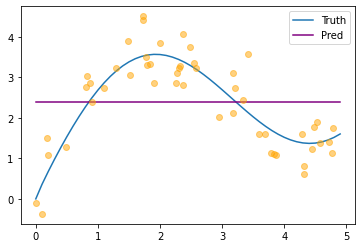

In [6]:
n_test = len(x_test)
y_hat = tf.repeat(tf.reduce_mean(y_train), repeats = n_test)
plot_kernel_reg(y_hat)

## Nonparamteric attention pooling

$$f(x) = \Sigma_{i=1}^n{\frac{K(x - x_i)}{\Sigma_{j = 1}^n{K(x - x_j)}}y_i}$$
Where,
$$K(u) = \frac{1}{\sqrt{2\pi}}exp(-\frac{u^2}{2})$$

In [7]:
X_repeat = tf.repeat(tf.expand_dims(x_train, axis = 0), repeats = n_train, axis = 0)

In [8]:
attention_weights = tf.nn.softmax(-(X_repeat - tf.expand_dims(x_train, axis = 1))**2/2, axis = 1)

In [9]:
y_hat_kernel_reg = tf.matmul(attention_weights, tf.expand_dims(y_train, axis = 1))

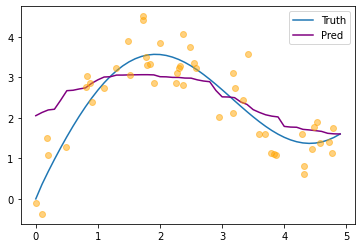

In [10]:
plot_kernel_reg(y_hat_kernel_reg)

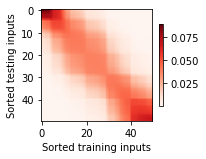

In [11]:
show_heatmaps(tf.expand_dims(tf.expand_dims(attention_weights, axis = 0), axis = 0),
              xlabel='Sorted training inputs',
              ylabel='Sorted testing inputs')

## Parametric attention pooling

In [12]:
class NWKernelRegression(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable(initial_value = tf.random.uniform(shape = (1,)))
        
    def call(self, queries, keys, values, **kwargs):
        # For training queries are `x_train`. Keys are distance of taining data for each point. Values are `y_train`.
        queries = tf.repeat(tf.expand_dims(queries, axis = 1), repeats = keys.shape[1], axis = 1)
        self.attention_weights = tf.nn.softmax(-((queries - keys) * self.w)**2 /2, axis = 1)
        return tf.squeeze(tf.matmul(tf.expand_dims(self.attention_weights, axis = 1), tf.expand_dims(values, axis = -1)))

In [13]:
X_tile = tf.repeat(tf.expand_dims(x_train, axis = 0), repeats = n_train, axis = 0)
Y_tile = tf.repeat(tf.expand_dims(y_train, axis = 0), repeats = n_train, axis = 0)

keys = tf.reshape(X_tile[tf.cast(1 - tf.eye(n_train), dtype = tf.bool)], shape = (n_train, -1))
values = tf.reshape(Y_tile[tf.cast(1 - tf.eye(n_train), dtype = tf.bool)], shape = (n_train, -1))

In [14]:
model = NWKernelRegression()
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.5)

In [15]:
def train_step(model, queries, keys, values, targets):
    with tf.GradientTape() as t:
        loss = loss_object(targets, model(queries, keys, values))/2 * len(targets) # To be consistent with d2l book.
    grads = t.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, model.trainable_variables[0]

In [16]:
epochs = 5
for epoch in range(epochs):
    current_loss, weight_value = train_step(model, x_train, keys, values, y_train)
    print("Epoch {0}: Loss = {1:.4f}, variable_value: {2:.4f}".
          format(epoch+1, current_loss.numpy(), weight_value.numpy().tolist()[0]))

Epoch 1: Loss = 33.8566, variable_value: 0.0657
Epoch 2: Loss = 33.8376, variable_value: 0.3809
Epoch 3: Loss = 32.1938, variable_value: 7.0556
Epoch 4: Loss = 7.4384, variable_value: 7.0772
Epoch 5: Loss = 7.4375, variable_value: 7.0987


In [17]:
y_hat_param_attention = model(tf.cast(x_test, dtype = tf.float32), keys, values)

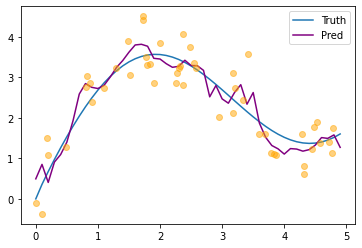

In [18]:
plot_kernel_reg(y_hat_param_attention)

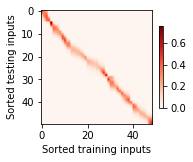

In [19]:
show_heatmaps(tf.expand_dims(tf.expand_dims(model.attention_weights, axis = 0), axis = 0),
              xlabel='Sorted training inputs',
              ylabel='Sorted testing inputs')